In [2]:
import glob

import matplotlib.pyplot as plt

plt.style.use("default")
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from src.classes import Boundary
from src.performance_evaluation import (
    center_of_mass,
    compute_position_error,
    compute_volume_error,
    compute_voxel_error,
)
from src.util import plot_voxel, plot_voxel_c, voxel_ball

print(tf.__version__)
# for scope
# from tensorflow import distribute as dist
import os

import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

boundary = Boundary()

2024-06-05 13:33:38.982704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


In [2]:
from dataclasses import dataclass


@dataclass
class BallAnomaly:  #  FOR VAE TRAINING ONLY
    x: float
    y: float
    z: float
    d: float
    γ: float

# Stage 1

Build the variational autoencoder $\mathbb{VAE}$ to learn a latent representation $\mathbf{z}$ of the domain $\Omega \in \mathbb{R}^3$.

Object radius

- 20mm $\rightarrow$ `d = 4`
- 30mm $\rightarrow$ `d = 6`
- 40mm $\rightarrow$ `d = 8`

Literature

- [Variational Autoencoder (VAE) with Discrete Distribution using Gumbel Softmax](https://towardsdatascience.com/variational-autoencoder-vae-with-discrete-distribution-using-gumbel-softmax-b3f749b3417e)

- [Tutorial: Categorical Variational Autoencoders using Gumbel-Softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html)

- [Categorical Reparameterization with Gumbel-Softmax](https://github.com/EderSantana/gumbel)
    - [GitHub Categorical Reparameterization with Gumbel-Softmax](https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb)


- [CAT VAE](https://github.com/flatironinstitute/catvae)

In [3]:
ball = BallAnomaly(x=10.5, y=10, z=10, d=4, γ=1)

In [4]:
ball_vxl = voxel_ball(ball, boundary)

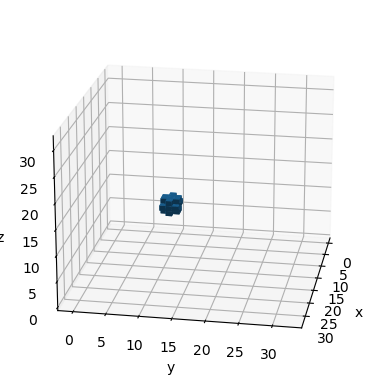

In [5]:
plot_voxel(ball_vxl)

In [6]:
X_all_anomalys = list()
diameter_labels = list()
pos_ball = list()
vol_ball = list()

max_d = 8

for γ in [1]:  # set object geometries to 1 and empty space to 0
    for d in [4, 6, 8]:  # diameter
        for x in np.linspace(boundary.x_0 + max_d, boundary.x_length - max_d, 15):
            for y in np.linspace(boundary.y_0 + max_d, boundary.y_length - max_d, 15):
                for z in np.linspace(
                    boundary.z_0 + max_d, boundary.z_length - max_d, 15
                ):
                    ball = BallAnomaly(x, y, z, d, γ)
                    vxl_ball = voxel_ball(ball, boundary)

                    X_all_anomalys.append(vxl_ball)
                    diameter_labels.append(d)
                    pos_ball.append([ball.y, ball.x, ball.z])  #  y,x,z in 3d Plot!!!
                    vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

X_all_anomalys = np.array(X_all_anomalys) / 2
diameter_labels = np.array(diameter_labels)
pos_ball = np.array(pos_ball)
vol_ball = np.array(vol_ball)

In [7]:
print(X_all_anomalys.shape, diameter_labels.shape)

(10125, 32, 32, 32) (10125,)


In [8]:
(
    X_train,
    X_test,
    r_train,
    r_test,
    pos_train,
    pos_test,
    vol_train,
    vol_test,
) = train_test_split(
    X_all_anomalys,
    diameter_labels,
    pos_ball,
    vol_ball,
    train_size=0.9,
    shuffle=True,
    random_state=42,
)

In [9]:
print(
    X_train.shape,
    X_test.shape,
    r_train.shape,
    r_test.shape,
    pos_train.shape,
    pos_test.shape,
    vol_train.shape,
    vol_test.shape,
)

(9112, 32, 32, 32) (1013, 32, 32, 32) (9112,) (1013,) (9112, 3) (1013, 3) (9112,) (1013,)


4564
Pos:	 [19.42857143 20.57142857 24.        ]
Vol:	 114


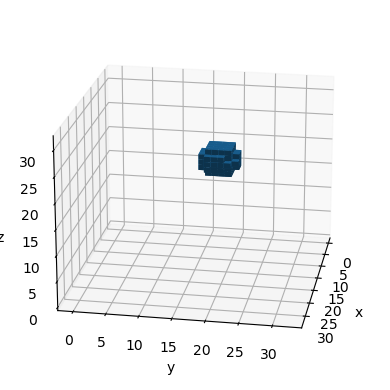

1896
Pos:	 [22.85714286 19.42857143 10.28571429]
Vol:	 271


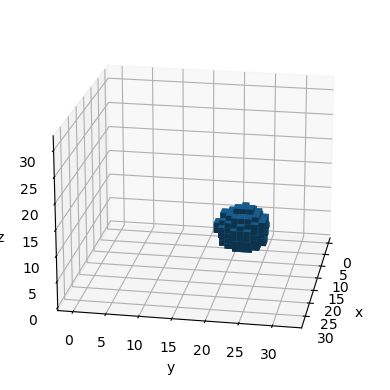

7173
Pos:	 [14.85714286 22.85714286 24.        ]
Vol:	 29


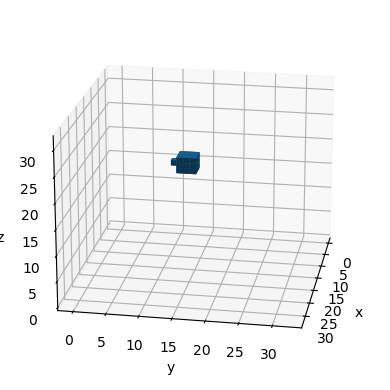

7441
Pos:	 [ 8.         19.42857143 18.28571429]
Vol:	 265


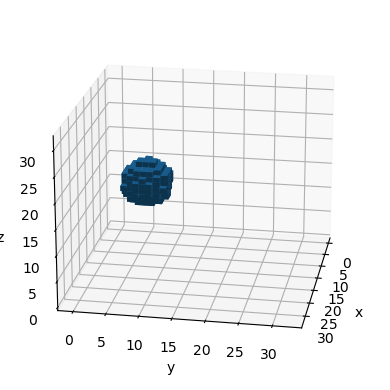

590
Pos:	 [24.         22.85714286 10.28571429]
Vol:	 265


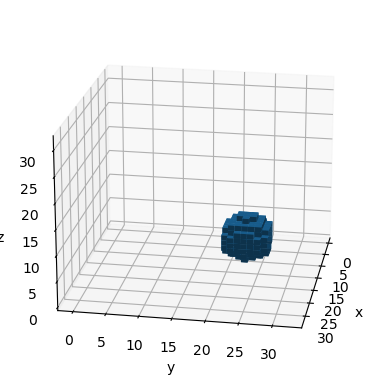

In [10]:
for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    print(rdn)
    print("Pos:\t", pos_train[rdn])
    print("Vol:\t", vol_train[rdn])
    plot_voxel_c(X_train[rdn, ...] * 2)

In [91]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.backend import random_normal
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv3D,
    Conv3DTranspose,
    Dense,
    Flatten,
    Input,
    Layer,
    Reshape,
)
from tensorflow.keras.losses import (
    binary_crossentropy,
    mean_absolute_error,
    mean_squared_error,
)
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

filters = [1, 2, 4, 8]
kernels = [(5, 5, 5) for _ in range(4)]
strides = [(1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2)]
paddings = ["same", "same", "same", "same"]

latent_dim = 8


class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            kl_loss = 1 + z_log_var - tf.pow(z_mean, 2) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
            reconstruction_loss = binary_crossentropy(
                data, reconstruction, axis=(1, 2, 3)
            )  #
            reconstruction_loss *= np.prod((32, 32, 32, 1))
            # β-VAE
            # print("beta value:",self.beta)
            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update(
            {
                "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
                "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
                "beta": self.beta,
            }
        )
        return config


def encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
):
    encoder_inputs = Input(shape=input_shape)
    x = BatchNormalization()(encoder_inputs)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3D(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean", activation="sigmoid")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(512, activation="relu")(latent_inputs)
    x = Reshape((4, 4, 4, 8))(x)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3DTranspose(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    decoded = x

    return latent_inputs, decoded


def vae_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
    beta=1.0,
):
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters,
        kernels=kernels,
        strides=strides,
        paddings=paddings,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

    decoder_inputs, decoder_outputs = decoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters[::-1],
        kernels=kernels[::-1],
        strides=strides[::-1],
        paddings=paddings[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

    return VAE(encoder, decoder, beta=beta)


# engineering decoder and encoder parts:

encoder_inputs, z_mean, z_log_var, z = encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
)
encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

decoder_inputs, decoder_outputs = decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
)
decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

encoder.summary()
decoder.summary()

Model: "VAE_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ input_layer_28[0… │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_56 (Conv3D)  │ (None, 32, 32,    │        126 │ batch_normalizat… │
│                     │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │          4 │ conv3d_56[0][0]   │
│ (BatchNormalizatio… │ 32, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_57 (Conv3D)  │ (None, 16, 16,    │        252 │ batch_normalizat… │
│                     │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │          8 │ conv3d_57[0][0]   │
│ (BatchNormalizatio… │ 16, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_58 (Conv3D)  │ (None, 8, 8, 8,   │      1,004 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │         16 │ conv3d_58[0][0]   │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_59 (Conv3D)  │ (None, 4, 4, 4,   │      4,008 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 4,   │         32 │ conv3d_59[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      4,104 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      4,104 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_14         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,662 (53.37 KB)

 Trainable params: 13,630 (53.24 KB)

 Non-trainable params: 32 (128.00 B)

Model: "VAE_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 4, 4, 4, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_56             │ (None, 8, 8, 8, 8)     │         8,008 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 8, 8, 8, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_57             │ (None, 16, 16, 16, 4)  │         4,004 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 16, 16, 16, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_58             │ (None, 32, 32, 32, 2)  │         1,002 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 32, 32, 32, 2)  │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_59             │ (None, 32, 32, 32, 1)  │           251 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 32, 32, 32, 1)  │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,933 (70.05 KB)

 Trainable params: 17,903 (69.93 KB)

 Non-trainable params: 30 (120.00 B)

In [93]:
# |--------------------------------------------------------- HPT -------------------------------------------------------|
# | model  1: epochs = 500, batch_size = 128, beta = 1.05, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  2: epochs = 500, batch_size = 128, beta = 1.04, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  3: epochs = 500, batch_size = 128, beta = 1.03, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  4: epochs = 500, batch_size = 128, beta = 1.02, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  5: epochs = 500, batch_size = 128, beta = 1.01, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# |                                                                                            |
# | model  6: epochs = 500, batch_size = 128, beta = 1.00, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  7: epochs = 500, batch_size = 128, beta = 0.99, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  8: epochs = 500, batch_size = 128, beta = 0.98, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model  9: epochs = 500, batch_size = 128, beta = 0.97, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 10: epochs = 500, batch_size = 128, beta = 0.96, kernels = (4, 4, 4),filters = [1, 2,  4,  8], latent_dim = 8 |
# |                                                                                            |
# | model 11: epochs = 500, batch_size = 128, beta = 1.04, kernels = (3, 3, 3),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 12: epochs = 500, batch_size = 128, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8*|
# | model 13: epochs = 500, batch_size = 128, beta = 1.04, kernels = (6, 6, 6),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 14: epochs = 500, batch_size = 128, beta = 1.04, kernels = (7, 7, 7),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 15: epochs = 500, batch_size = 128, beta = 1.04, kernels = (9, 9, 9),filters = [1, 2,  4,  8], latent_dim = 8 |
# |                                                                                            |
# | model 16: epochs = 500, batch_size =  32, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 17: epochs = 500, batch_size =  64, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 18: epochs = 500, batch_size = 128, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 19: epochs = 500, batch_size = 256, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 20: epochs = 500, batch_size = 512, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# |                                                                                            |
# | model 21: epochs = 500, batch_size =  32, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 22: epochs = 500, batch_size =  16, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 23: epochs = 500, batch_size =   8, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 24: epochs = 200, batch_size =   4, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# | model 25: epochs = 200, batch_size =   2, beta = 1.04, kernels = (5, 5, 5),filters = [1, 2,  4,  8], latent_dim = 8 |
# |---------------------------------------------------------------------------------------------------------------------|

# learning_rate = 0.0001
# sgd = SGD(learning_rate = learning_rate_1, momentum = 0.9, nesterov = True)
# vae.compile(optimizer = SGD())# , metrics = ['accuracy']

epochs = 500
batch_size = 32
beta = 1.04  #  best value from hpt

cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

vae = vae_model(input_shape=(32, 32, 32, 1), filters=[1, 4, 8, 16], beta=beta)
vae.compile(optimizer=Adam())  # learning_rate = learning_rate

history = vae.fit(
    np.expand_dims(X_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[cb],
)

Epoch 1/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - kl_loss: 10.9132 - loss: 543.3021 - reconstruction_loss: 531.7943 - total_loss: 543.1441
Epoch 2/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 7.8554 - loss: 445.9562 - reconstruction_loss: 437.6073 - total_loss: 445.7769
Epoch 3/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 21.1343 - loss: 276.8876 - reconstruction_loss: 254.8670 - total_loss: 276.8466
Epoch 4/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 20.5342 - loss: 252.4285 - reconstruction_loss: 231.1031 - total_loss: 252.4586
Epoch 5/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 154.7884 - loss: 594.6354 - reconstruction_loss: 432.9144 - total_loss: 593.8944
Epoch 6/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 28.0052 - loss: 256.2829 - reconstruction_loss: 227.1877 - total_loss: 256.3130
Epoch 7/500
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 24.2645 - loss: 257.4965 - reconstruction_loss: 232.2296 - total

KeyboardInterrupt: 

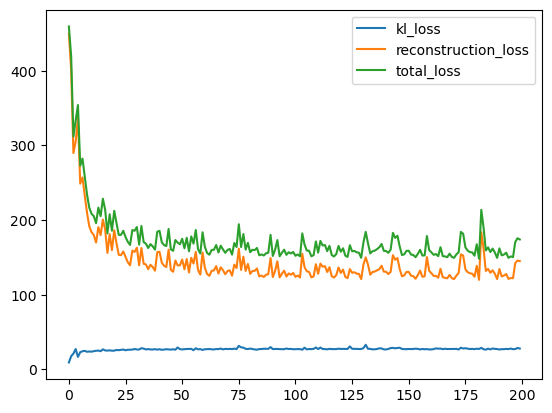

In [67]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

In [68]:
vae_idx = len(glob.glob("models/vaes/*.h5")) + 1
vae.save_weights(f"models/vaes/vae_{vae_idx}.weights.h5")

In [69]:
# vae_idx = 2
# vae.load_weights(f"models/vaes/vae_{vae_idx}.weights.h5")

Original...


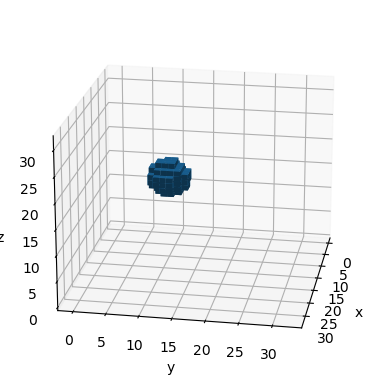

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


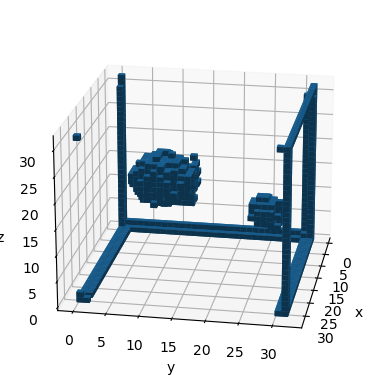

Original...


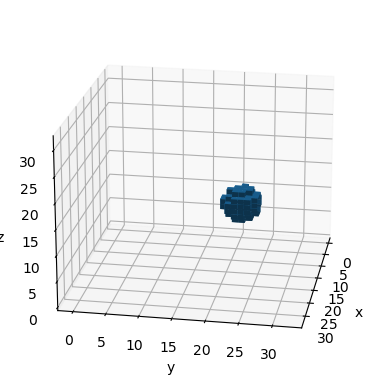

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


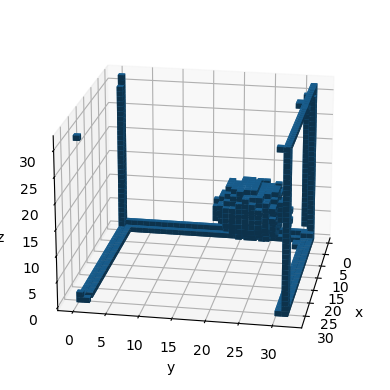

Original...


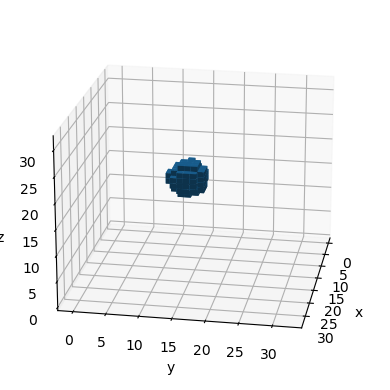

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


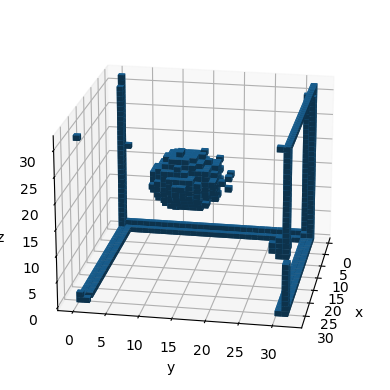

Original...


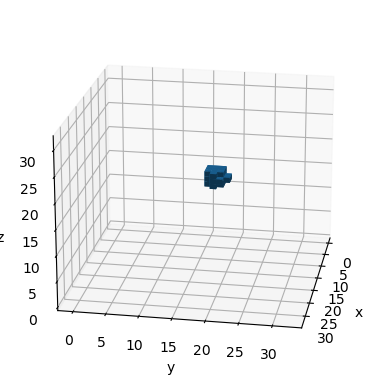

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


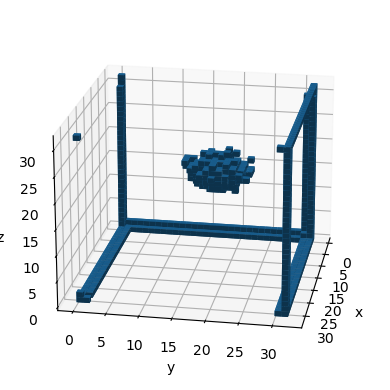

Original...


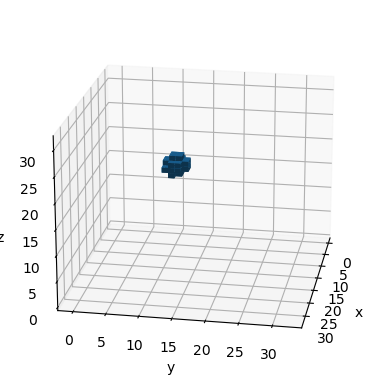

Prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


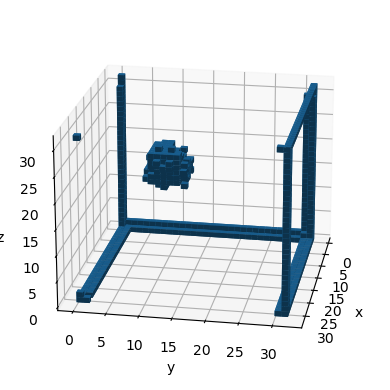

In [70]:
plt.style.use("default")
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    print("Original...")
    plot_voxel_c(X_test[rdn, ...])

    print("Prediction...")
    _, _, z = vae.encoder.predict(np.expand_dims(X_test[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(sgl_pred, axis=4)
    sgl_pred = np.squeeze(sgl_pred, axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    # sgl_pred = np.round(sgl_pred, 1) + 0.35  #  round offset
    # sgl_pred = np.round(sgl_pred)
    plot_voxel_c(sgl_pred)

In [71]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list(), test_idx=list())
# Apply test data to previously trained VAE
_, _, z = vae.encoder.predict(X_test)
X_pred = vae.decoder.predict(z)
X_pred = np.squeeze(X_pred, axis=4)
X_pred = np.clip(X_pred, a_min=0, a_max=1)
# X_pred = np.round(X_pred, 1) + 0.15  #  round offset
# X_pred = np.round(X_pred)


data_append = []

for idx, v_err in enumerate(compute_volume_error(X_pred, X_test)):
    v_percent = (v_err / 32**3) * 100
    data_append.append(
        dict(Model=vae_idx, Error_val=v_percent, Error="Volume", test_idx=idx)
    )

for idx, p_err in enumerate(compute_position_error(pos_test, X_pred)):
    p_percent = (p_err / np.linalg.norm(np.array([32, 32, 32]))) * 100
    data_append.append(
        dict(Model=vae_idx, Error_val=p_percent, Error="Position", test_idx=idx)
    )

# Iterativ das Dictionary erweitern
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [72]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(f"models/vaes/vae_acc_measure_{vae_idx}.csv", index=False)
acc_measure_df

,Model,Error_val,Error,test_idx
0,25,4.150391,Volume,0
1,25,3.073120,Volume,1
2,25,2.804565,Volume,2
3,25,4.040527,Volume,3
4,25,2.273560,Volume,4
...,...,...,...,...
2021,25,0.963205,Position,1008
2022,25,3.811637,Position,1009
2023,25,3.421075,Position,1010
2024,25,2.227958,Position,1011


Text(0, 0.5, 'Error (%)')

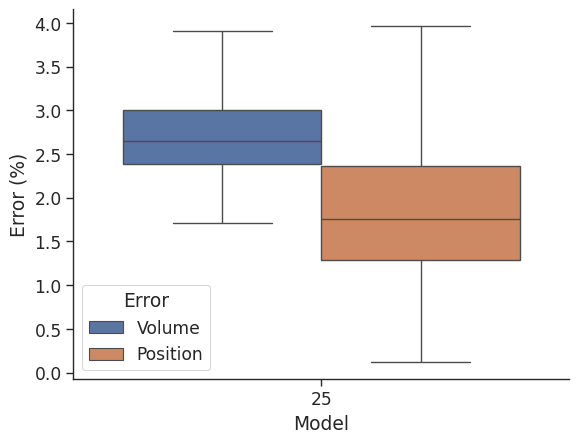

In [73]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(
    x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=False
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

**Append Stats**

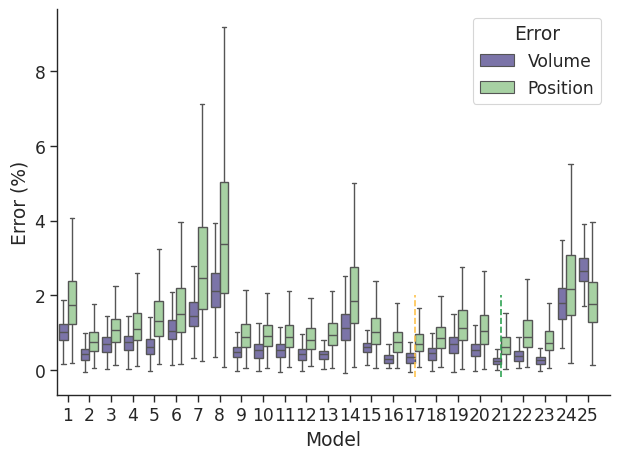

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

combined_df = pd.concat(
    [pd.read_csv(f_csvs) for f_csvs in glob.glob("models/vaes/vae_acc_measure_*.csv")],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)
# combined_df.to_csv(f"models/vaes/all_measures.csv", index=False)
custom_palette = ["#756bb1", "#a1d99b"]
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=False,
    palette=custom_palette,
)  #  violinplot: , split=True
plt.ylabel("Error (%)")
# plt.vlines(16 - 1, -0.2, 2, colors="#e34a33", linestyle="dashed")
plt.vlines(17 - 1, -0.2, 2, colors="#fec44f", linestyle="dashed")
plt.vlines(21 - 1, -0.2, 2, colors="#31a354", linestyle="dashed")
plt.tight_layout()
plt.xlim([-0.5, 25])
plt.savefig("images/vae_hpt.pdf")
plt.savefig("images/vae_hpt.png")
plt.show()

In [312]:
# planets.groupby("method").distance.median()
# min(d), np.quantile(d, 0.25), np.median(d), np.quantile(d, 0.75), max(d)

## Hyperparametertuning

## Further evaluation